# BE/Bi 103, Fall 2015: Homework 3
## Due 1pm, Monday, October 19

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw3_protected.ipynb).*

In [2]:
# The workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special

# Plotting modules
import matplotlib.pyplot as plt

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

### Problem 3.1: Detecting horizonatal gene transfer (50 pts)
You heard Griffin talk about his research during Tutorial 3.  Now is your chance to work with some of his data.  The data sets may be downloaded [here](http://bebi103.caltech.edu/2015/protected/data/chure.zip).  Be sure to read the header comments.

**a)** For each data set, compute the number of of transformed cells.  You will have to decide on a criterion for what constitutes a transformed cell.  Comment on how you decided on this criterion.

**b)** For each plasmid concentration, compute and plot the posterior distribution, $P(p\mid n_t, n, I)$, where $n_t$ out of $n$ cells are determined to have been transformed, and $p$ is the probability that any given cell is transformed.  Do this for both the anaerobic and aerobic data sets.

**c)** Show that the posterior distribution may be approximated as a Gaussian distribution with mean $p^* = n_t/n$ and variance

\begin{align}
\sigma^2 = \frac{(p^*)^2 (1 - p^*)^2}{n(p^*)^2 + n_t(1-2p^*)}.
\end{align}

Comment on any potential issues you see with this approximation.

**d)** Plot $p^*$ versus the plasmid concentration with error bars given by the values of $\sigma$ you calculated in part (c).  Think carefully about how you display this plot.

**e)** Griffin and I came up with a model to describe transformation.  We assumed that update of plasmic DNA is a Poisson process.  Therefore, the time $t$ required to take in a plasmid is exponentially distributed.

\begin{align}
P(t\mid r) = r\, \mathrm{e}^{-rt},
\end{align}

where $r$ is the rate of plasmid uptake.  We further assumed that $r$ is a linear function of the plasmid concentration, $c$, $r(c) = r_0c$.  Thus,

\begin{align}
P(t\mid r_0, c) = r_0 c \, \mathrm{e}^{-r_0 c t}.
\end{align}

The cells had plasmid available to them for a time $\tau = 1$ hour before washing out the plasmid DNA.  We assume that a cell that takes in at least one plasmid expresses YFP and will therefore be marked as transformed.  Therefore, the probability that a given cell took in no plasmids at all is

\begin{align}
P(\text{no plasmid}) = \int_\tau^\infty \mathrm{d}t\,P(t\mid r_0, c)
= \int_\tau^\infty \mathrm{d}t\,r_0 c \, \mathrm{e}^{-r_0 c t}
= \mathrm{e}^{-r_0 c \tau}.
\end{align}

Thus, the probability that a cell takes in at least one plasmid, which in our model is the probability that the cell is transformed, is 

\begin{align}
p = 1 - \mathrm{e}^{-r_0 c \tau}.
\end{align}

This is our theoretical model for $p$ as a function of the plasmid concentration.  We know $\tau = 1$ hour, so the parameter we are trying to fit is $r_0$, which describes the rate at which *Bacillus* is capable of taking in plasmid under aerobic or anaerobic conditions.

Find the most probable value of $r_0$ for the aerobic and for the anaerobic growth conditions, along with error bars.  Add the regression lines to the plot you made in part (d).  Comment on the results.  Are you satisfied with the proposed model?  Do you have any other suggestions?

*Hint*: For each plasmid concentration $c_i$, you computed $p_i^*$ and an error bar, $\sigma_i$.  Use these to construct your likelihood.  Since you have measured the $\sigma_i$'s, the only fit parameter is $r_0$.

In [3]:
# Plot posteriors for each
def log_posterior(n_r, n, p):
    """
    Log posterior of reversal measurements.
    """
    return scipy.special.gammaln(n+2) - scipy.special.gammaln(n_r + 1) \
              - scipy.special.gammaln(n - n_r + 1) \
              + n_r * np.log(p) + (n - n_r) * np.log(1 - p)
        
def process(fname):
    df = pd.read_csv(fname, comment='#')
    df.columns = [0, 10, 100, 1000, 10000, 100000]
    df = pd.melt(df, var_name='plasmids/cell', value_name='mean fluor').dropna()
    
    # Determine cutoff (5 stds out)
    inds = (df['plasmids/cell'] == 0)
    auto_std = df[inds]['mean fluor'].std()
    cutoff = df[inds]['mean fluor'].mean() \
            + max(df[inds]['mean fluor'].max(), 5 * auto_std)
        
    # Number of fluorescent cells for each plasmid density
    df_n = pd.DataFrame(columns=['plasmids/cell', 'n_trans', 'n', 'p', 'sigma'])
    plas_dens = df['plasmids/cell'][df['plasmids/cell'] > 0].unique()
    for plas in plas_dens:
        n = (df['plasmids/cell'] == plas).sum()
        n_trans = ((df['plasmids/cell'] == plas) 
                           & (df['mean fluor'] > cutoff)).sum()
        p = n_trans / n
        sigma = np.sqrt(p**2 * (1 - p)**2 / (n * p**2 + n_trans * (1 - 2 * p)))
        df_n = df_n.append(pd.DataFrame(
                np.array([[plas, n_trans, n, p, sigma]]), columns=df_n.columns),
                                            ignore_index=True)
    return df_n

df_ae = process('../data/chure/20151001_aerobic_mean_intensities.csv')
df_an = process('../data/chure/20151001_anaerobic_mean_intensities.csv')

(9, 110000.0)

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


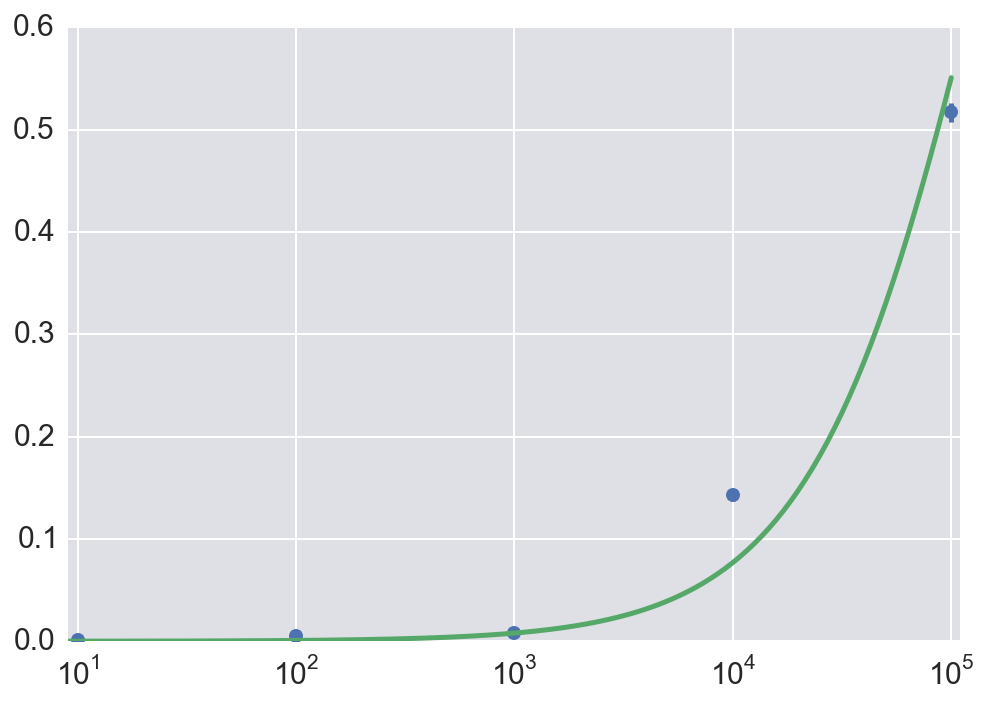

In [12]:
def p_curve(r_0_tau, c):
    return 1 - np.exp(-r_0_tau * c)

def resid(r_0_tau, c, p, sigma):
    return (p - p_curve(r_0_tau[0], c)) / sigma

r_0_tau0 = np.array([1e-3])
args = (df_ae['plasmids/cell'], df_ae['p'], df_ae['sigma'])
popt, _ = scipy.optimize.leastsq(resid, r_0_tau0, args=args)

fig, ax = plt.subplots()
c_plot = np.logspace(0, 5, 300)
ax.errorbar(df_ae['plasmids/cell'], df_ae['p'], 
                 yerr=df_ae['sigma'], marker='o', linestyle='none')
ax.plot(c_plot, p_curve(popt[0], c_plot), '-')
ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposx='clip')
ax.set_xlim((9, 1.1e5))
# ax.set_ylim((1e-6, 1))

In [5]:
popt

array([  1.23404201e-06])

(1e-06, 1)

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


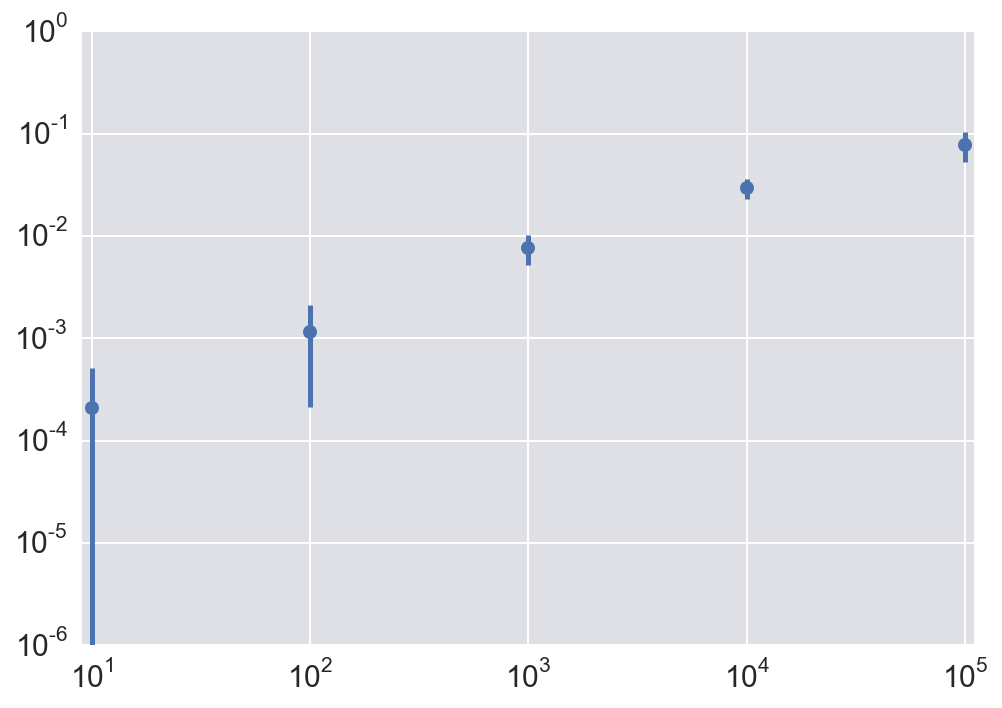

In [76]:
fig, ax = plt.subplots()
ax.errorbar(df_n_aero['plasmids/cell'], df_n_aero['p'], 
                 yerr=2*df_n_aero['sigma'], marker='o', linestyle='none')
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.set_xlim((9, 1.1e5))
ax.set_ylim((1e-6, 1))

In [18]:
cutoff

217.5358469408378

In [ ]:
df[inds]['mean fluor']

<br />

### Problem 3.2: Dorsal gradients in *Drosophila* embryos (70 pts)
We will use a data set from [Angela Stathopoulos's lab](http://www.stathlab.caltech.edu), acquired to study morphogen profiles in developing fruit fly embryos.  The original paper is [Reeves, Trisnadi, et al., Dorsal-ventral gene expression
in the *Drosophila* embryo reflects the dynamics and precision of the Dorsal nuclear gradient, *Dev. Cell.*, **22**, 544-557, 2012](http://bebi103.caltech.edu/2015/protected/papers/reeves_2012.pdf), and the data set may be downloaded [here](http://bebi103.caltech.edu/2015/protected/data/reeves_et_al.zip).

In this experiment, Reeves, Trisnadi, and coworkers measured expression levels of a fusion of Dorsal, a morphogen transcription factor important in determining the dorsal-ventral axis of the developing organism, and Venus, a yellow fluorescent protein along the dorsal/ventral- (DV) coordinate.  They put this construct on the third chromosome, while the wild type *dorsal* is on the second.  Instead of the wild type, they had a homozygous *dorsal*-null mutant on the second chromosome.  The Dorsal-Venus construct rescues wild type behavior, so they could use this construct to study Dorsal gradients.

Dorsal shows higher expression on the ventral side of the organism, thus giving a *gradient* in expression from dorsal to ventral which can be ascertained by the spatial distribution of Venus fluorescence intensity.

This can be seen in the image below, which is a cross section of a fixed embryo with anti-Dorsal staining.  The bottom of the image is the ventral side and the top is the dorsal side of the embryo.  The DV coordinate system is defined by the yellow line.  It is periodic, going from $-1$ to $1$.  The DV-coordinate is therefore defined in relative terms around the embryo and is dimensionless.  The ventral nuclei show much higher expression of Dorsal.  The image is adapted from the Reeves, Trisnadi, et al. paper.

<img src="DV_coord.png">

*A quick note on nomenclature:* Dorsal (capital D) is the name of the protein product of the gene *dorsal* (italicized).  The dorsal (adjective) side of the embryo is its back.  The ventral side is its belly.  Dorsal is expressed more strongly on the ventral side of the developing embryo.  This can be confusing.

To quantify the gradient, Reeves, Trisnadi, and coworkers had to first choose a metric for describing it.  They chose to fit the measured profile of fluorescence intensity with a Gaussian (plus background) and use the standard deviation of that Gaussian as a metric for the width of the Dorsal gradient.  This provides a nice motivation for doing nonlinear regression.

Upon unzipping the data sets, you will find the file `reeves_dv_profile_over_time.csv`.  This contains the measured level of fluorescence intensity coming from the Dorsal-Venus construct at different stages of development.  Timing of development in the *Drosophila* embryo based on *nuclear cycles*, the number of nuclear divisions that have happened since fertilization.  Prior to cellularization of the syncytium, there are 14 rounds of nuclear division.  Reeves, Trisnadi, et al. measured Dorsal-Venus expression at nuclear cycle 11, 12, 13, and 14.

**a)** Comment on the choice of a Gaussian-plus-background function to fit the data.  Why do you think this was chosen?  Do you have other suggestions?

**b)** Write down expressions for the likelihood, prior, and posterior for a regression of this sort of data.  Be sure to explicitly state which assumptions go into these choices.

**c)** Perform regressions to quantify the width of the Dorsal-Venus gradient at each nuclear cycle.  Be sure to report error bars on the parameters you obtain.  You should also plot the gradient corresponding to the most probable parameter values along with the experimentally observed data points.

**d)** Reeves performed regressions like you have just done on many samples, including different methods of imaging.  These data are contained in the file `reeves_gradient_width_various_methods.csv`.  Be sure to read the comments describing the data.  Generate a plot summarizing these data.  Discuss your choice for how you chose to render your plot.  Based on what you see, is the Venus fusion a reasonable way to study the Dorsal gradient, as compared to the wild type cross-section gold standard?

<br />

### Problem 3.3: HIV clearance and a warning about regressions (20 pts extra credit)

A human immunodeficiency virus (HIV) is a virus that causes host organisms to develop a weaker, and sometimes ineffective, immune system. HIV inserts its viral RNA into a target cell of the immune system.  This virus gets reverse transcribed into DNA and integrated into the host cell's chromosomes.  The host cell will then transcribe the integrated DNA into mRNA for the production of viral proteins and produce new HIV.  Newly created viruses then exit the cell by budding off from the host.  HIV carries the danger of ongoing replication and cell infection without termination or immunological control.  Because CD4 T cells, which communicate with other immune cells to activate responses to foreign pathogens, are the targets for viral infection and production, their infection leads to reductions in healthy CD4 T cell production, causing the immune system to weaken.  This reduction in the immune response becomes particularly concerning after remaining infected for longer periods of time, leading to acquired immune deficiency syndrome (AIDS).

Perelson and coworkers have developed mathematical models to study HIV populations in the eukaryotic organisms.  HIV-1 will infect cells at a rate $k$ and is produced from these infected T cells at a rate $p$.  On the other hand, the viruses are lost due to clearance by the immune system of drugs, which occurs at a rate $c$, and infected cells die at a rate $\delta$ (Figure from [Perelson, *Nat. Rev. Immunol.*, **2**, 28-36, 2002](../protected/paper/perel_son2002.pdf))

![/Basic model of viral infection](hiv_figure.jpg "Basic model of viral infection Perelson Nat. Rev. Immunol. 2002)")

The above process can be written down as a system of differential equations.

\begin{align}
\frac{dT^*}{dt} &= k V_I T - \delta T^*\\[1em]
\frac{dV_I}{dt} &= -cV_I\\[1em]
\frac{dV_{NI}}{dt} &= N \delta T^{*} - c V_{NI},
\end{align}

Here, $T(t)$ is the number of uninfected T-cells at time $t$, and $T^*$ is the number of infected T cells. Furthermore, there is a concentration $V_I(t)$ of infectious viruses that infect T cells at the rate $k$.  We also have a concentration $V_{NI}$ of innocuous viruses. We define $N(t)$ to be the number of newly produced viruses from one infected cell over this cell's lifetime.  We can measure the total viral load, $V(t) = V_I(t) + V_{NI}(t)$.  If we initially have a viral load of $V(0) = V_0$, we can solve the system of differential equations to give

\begin{align}
V(t) = V_0e^{-ct} + \frac{cV_0}{c-\delta}\left[\frac{c}{c-\delta}(e^{-{\delta}t} - e^{-ct}) - {\delta}te^{-ct}\right].
\end{align}

We will take viral load data from a real patient (which you can download [here](../data/hiv_data/csv)) and perform a regression to evaluate the parameters $c$ and $\delta$.  The drug Ritonavir is a protease inhibitor that serves to clear the viruses; i.e., it modulates $c$. So, $c$ is a good parameter to use to understand the efficacy of a drug.

**a)** Perform a regression on these data using the theoretical temporal curve for the viral load.

**b)** Plot the posterior distribution over the interval $0 \le \delta, c \le 10$ days$^{-1}$.  Does this plot raise any serious issues about how you estimate $c$ and $d$.  What experiments might you propose to help deal with these problems?

<br />

### Problem 3.4 Connections in the human brain
This problem may be viewed [here](../protected/homework/hw3_protected.html).